<a href="https://colab.research.google.com/github/nidhihegde001/CRISMIS/blob/master/rpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets.voc import VisionDataset
import torch.nn.functional as F

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/exp2')

In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
#increasing the default plot size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import collections

In [ ]:
class Cosmic_Detection(VisionDataset):
  def __init__(self,
                root,                 
                mode='train',
                transform=None,
                target_transform=None,
                transforms=None):
      super(Cosmic_Detection, self).__init__(root, transforms, transform, target_transform)

      voc_root = 'pascal_voc_roboflow'
      image_dir = os.path.join(voc_root, mode)
      annotation_dir = os.path.join(voc_root, mode +'_annots')

      if not os.path.isdir(voc_root):
          raise RuntimeError('Dataset not found or corrupted')

      file_names = []
      for f in os.listdir(image_dir):
        print(f)
        file_names.append(f[:-4])
      self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
      self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
      
      assert (len(self.images) == len(self.annotations))

  def __getitem__(self, index):
      img = Image.open(self.images[index]).convert('RGB')
      target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot())

      if self.transforms is not None:
          img, target = self.transforms(img, target)

      return img, target


  def __len__(self):
      return len(self.images)

  def parse_voc_xml(self, root):
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [ymin, xmin, ymax, xmax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        # extract all the classes
        labels = list()
        for category in root.findall('.//name'):
          labels.append(category.text)
        return boxes, labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/My Drive/CRISMIS/pascal_voc_roboflow.zip'

Archive:  /content/drive/My Drive/CRISMIS/pascal_voc_roboflow.zip
replace pascal_voc_roboflow/README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
data_dir = 'pascal_voc_roboflow/'

crismis_dataset = {x: Cosmic_Detection(None, x, data_transforms[x]) 
                  for x in ['train', 'valid']}

EW0215726557D_png.rf.fa9bb2830baa5e9f64dc38e31caf9d77.jpg
EN0215720395M_png.rf.9e9202af2ceec968a631ed52019d847e.jpg
EW0215729728I_png.rf.0871f90152d445c0dc81201f655964e3.jpg
EN0215720399M_png.rf.f2bb765d215e8ad620c6cfc7e7c4bef6.jpg
EW0215726573L_png.rf.3e23a7c6198c5fe1ea2dc7f920cbb39f.jpg
EN0215807259M_png.rf.79a56d5552155f98d5f6ec82ed6b5dab.jpg
EN0215850744M_png.rf.040f243220e2a42ece670f10e6735bc6.jpg
EW0215726573L_png.rf.03a9c06ddcdd41ccc94a8b34aebee062.jpg
EW0215815254F_png.rf.1264325bfac292f588e7e33ebcedc1b9.jpg
EW0215729736C_png.rf.cfd801ed971ee6238b6eb859f5aa5529.jpg
EW0215727940C_png.rf.a3d3a89cad16ee441e1946cf5da07293.jpg
EW0215727936F_png.rf.d7630207a364b5887e96f87ee5e2cc0d.jpg
EN0215720160M_png.rf.b0d1caf9aecf294c90f836fb71beb1f6.jpg
EW0215773244F_png.rf.4cd8ebd6b30f147e1a987c1d9530771c.jpg
EW0215726561E_png.rf.f3f8a0d3e4ca3d247f7672fd5a0ec660.jpg
EN0215728629M_png.rf.aa910d38b25dcbcfde4dc98c55c9b5ce.jpg
EW0215815250I_png.rf.4312f69933c1d8e4fe695cfce0a99e45.jpg
EW0215729736C_

In [ ]:
crismis_dataset['train'][61]

(tensor([[[-0.9608, -0.9608, -0.9608,  ..., -0.9373, -0.9373, -0.9373],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9373, -0.9373, -0.9373],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9373, -0.9373, -0.9373],
          ...,
          [-0.9608, -0.9529, -0.9451,  ..., -0.8588, -0.8588, -0.8588],
          [-0.9608, -0.9529, -0.9451,  ..., -0.8588, -0.8588, -0.8588],
          [-0.9608, -0.9529, -0.9451,  ..., -0.8588, -0.8588, -0.8588]],
 
         [[-0.9608, -0.9608, -0.9608,  ..., -0.9373, -0.9373, -0.9373],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9373, -0.9373, -0.9373],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9373, -0.9373, -0.9373],
          ...,
          [-0.9608, -0.9529, -0.9451,  ..., -0.8588, -0.8588, -0.8588],
          [-0.9608, -0.9529, -0.9451,  ..., -0.8588, -0.8588, -0.8588],
          [-0.9608, -0.9529, -0.9451,  ..., -0.8588, -0.8588, -0.8588]],
 
         [[-0.9608, -0.9608, -0.9608,  ..., -0.9373, -0.9373, -0.9373],
          [-0.9608, -0.9608,

In [ ]:
def imshow(inp, gt_bbox, anchors):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  ax = plt.gca()
  # plot each box
  for box in gt_bbox:
    # get coordinates
    y1, x1, y2, x2 = box
    # calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    # create the shape
    rect = Rectangle((x1, y1), width, height, fill=False, color='green')
    # draw the box
    ax.add_patch(rect)
  for box in anchors:
    # get coordinates
    y1, x1, y2, x2 = box
    # calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    # create the shape
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    # draw the box
    ax.add_patch(rect)
  plt.show()
    

In [ ]:
def get_gt_targets(data,index): # data is the training set

  # get gt data
  ind = index
  input_image = data[index][0].view(1,3,1024,1024)
  gt_bbox = np.array(data[index][1][0],dtype=np.float32)# y1,x1,y2,x2
  gt_labels = np.array(data[index][1][1])

  ratios = [0.5, 1, 2]
  anchor_scales = [16,32,64]
  fe_size = 32

  anchors = np.zeros((len(ratios) * len(anchor_scales)*fe_size *fe_size, 4),dtype=np.float32)
  ctr =  np.zeros((fe_size*fe_size,2),dtype=np.float32)
  print("Total no of anchors:", anchors.shape)

  # Generate centers for each feature map pixel
  pts = np.arange(31, (fe_size+1) * 32-1, 32)
  index = 0
  for x in range(len(pts)):
      for y in range(len(pts)):
          ctr[index, 1] = pts[x] - 16
          ctr[index, 0] = pts[y] - 16
          index +=1

  # Code to generate anchors at a location in Fmap
  index = 0
  for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
      for j in range(len(anchor_scales)):
        h = anchor_scales[j] * np.sqrt(ratios[i])
        w = anchor_scales[j] * np.sqrt(1./ ratios[i])
        anchors[index, 0] = ctr_y - h / 2.
        anchors[index, 1] = ctr_x - w / 2.
        anchors[index, 2] = ctr_y + h / 2.
        anchors[index, 3] = ctr_x + w / 2.
        index += 1
  print("Initial Anchors:")
  print(anchors)
  index_inside = np.where(
          (anchors[:, 0] >= 0) &
          (anchors[:, 1] >= 0) &
          (anchors[:, 2] < 1024) &
          (anchors[:, 3] < 1024)
      )[0]

  # Create labels and anchors for valid anchor boxes
  label = np.empty((len(index_inside), ), dtype=np.int32)
  # default initialisation
  label.fill(-1)
  print("Label shape:",label.shape)
  valid_anchors = anchors[index_inside]
  print("Valid anchors",valid_anchors)   
  if (len(gt_labels)==0):
    anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
    anchor_labels.fill(-1)
    anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchors.dtype)
    anchor_locations.fill(0)
    return anchor_labels,anchor_locations
  ious = np.empty((len(valid_anchors), len(gt_labels)), dtype=np.float32)
  ious.fill(0)

# Calculating iou
  for num1, i in enumerate(valid_anchors):
      ya1, xa1, ya2, xa2 = i  
      anchor_area = (ya2 - ya1) * (xa2 - xa1)
      for num2, j in enumerate(gt_bbox):
          yb1, xb1, yb2, xb2 = j
          box_area = (yb2- yb1) * (xb2 - xb1)
          inter_x1 = max([xb1, xa1])
          inter_y1 = max([yb1, ya1])
          inter_x2 = min([xb2, xa2])
          inter_y2 = min([yb2, ya2])
          if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
              iter_area = (inter_y2 - inter_y1)*(inter_x2 - inter_x1)
              iou = iter_area/(anchor_area+ box_area - iter_area)            
          else:
              iou = 0
          ious[num1, num2] = iou
  print('IOU shape:',ious.shape)

  print("**Case 1 begins...**")
  #case 1
  gt_argmax_ious = ious.argmax(axis=0)
  print("Indices with maximum overlap with each gt box:", gt_argmax_ious)
  # index 90 with gt1 and 130 with gt2 has maximum overlap
  gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
  print(gt_max_ious)
  # anchors with highest iou with gt box
  # gt_argmax_ious = np.where(ious == gt_max_ious)[0]
  # print("Indices with maximum overlap with each gt box:", gt_argmax_ious)
  print("their anchor locations:")
  print(valid_anchors[gt_argmax_ious])
  print("gt box locations:")
  print(gt_bbox)

  imshow(data[ind][0],gt_bbox,valid_anchors[gt_argmax_ious])

  print("**Case 2 begins...**")
  # case 2
  # which gt box has max iou with each anchor (box 0 or 1)
  argmax_ious = ious.argmax(axis=1)
  print('Which gt box has maximum overlap with each anchor:',argmax_ious)
  # max iou with gt box for each anchor
  max_ious = ious[np.arange(len(index_inside)), argmax_ious]
  print("Corresponding Maximum IOU for each anchor:",max_ious)

  # LABELLING GT ANCHORS
  print("LABELLING GT ANCHORS...")
  pos_iou_threshold  = 0.6
  neg_iou_threshold = 0.05
  label[max_ious < neg_iou_threshold] = 0
  label[gt_argmax_ious] = 1
  label[max_ious >= pos_iou_threshold] = 1

  # Creating 256 training samples,half positive, half negative
  pos_ratio = 0.5
  n_sample = 256
  n_pos = pos_ratio * n_sample
  pos_index = np.where(label==1)[0]
  print("No of positive labels:")
  print(pos_index.shape)
  # if len(pos_index) > n_pos:
  #     disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
  #     label[disable_index] = -1
  n_neg = n_sample-np.sum(label == 1)
  neg_index = np.where(label == 0)[0]
  print("No of negative labels:")
  print(neg_index.shape)
  if len(neg_index) > n_neg:
      disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
      label[disable_index] = -1

  final_neg_anchor_indices = np.where(label==0)[0]
  final_neg_anchors = valid_anchors[final_neg_anchor_indices]
  imshow(data[ind][0],valid_anchors[pos_index],final_neg_anchors)

# get the most probable gt_bbox at each valid anchor location 
  max_iou_bbox = gt_bbox[argmax_ious]

# Get the correct regression outputs
  print("Getting regression outputs...")
  height = valid_anchors[:, 2] - valid_anchors[:, 0]
  width = valid_anchors[:, 3] - valid_anchors[:, 1]
  ctr_y = valid_anchors[:, 0] + 0.5 * height
  ctr_x = valid_anchors[:, 1] + 0.5 * width
  base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
  base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
  base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
  base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width
  eps = np.finfo(height.dtype).eps
  height = np.maximum(height, eps)
  width = np.maximum(width, eps)
  dy = (base_ctr_y - ctr_y) / height
  dx = (base_ctr_x - ctr_x) / width
  dh = np.log(base_height / height)
  dw = np.log(base_width / width)
  anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
  print('Correct regression outputs of valid anchor locations=')
  print(anchor_locs)

  # Final labels
  anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
  anchor_labels.fill(-1)
  anchor_labels[index_inside] = label
  # Final locations
  anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
  anchor_locations.fill(0)
  anchor_locations[index_inside, :] = anchor_locs
  print("Final labels shape:",anchor_labels.shape)
  print("Final locaions shape:",anchor_locations.shape)
  return anchor_labels,anchor_locations
  

In [ ]:
def get_gt_targets_wo_print(data,index): # data is the training set

  # get gt data
  ind = index
  input_image = data[index][0].view(1,3,1024,1024)
  gt_bbox = np.array(data[index][1][0],dtype=np.float32)# y1,x1,y2,x2
  gt_labels = np.array(data[index][1][1])

  ratios = [0.5, 1, 2]
  anchor_scales = [16,32,64]
  fe_size = 32

  anchors = np.zeros((len(ratios) * len(anchor_scales)*fe_size *fe_size, 4),dtype=np.float32)
  ctr =  np.zeros((fe_size*fe_size,2),dtype=np.float32)
  # print("Total no of anchors:", anchors.shape)

  # Generate centers for each feature map pixel
  pts = np.arange(31, (fe_size+1) * 32-1, 32)
  index = 0
  for x in range(len(pts)):
      for y in range(len(pts)):
          ctr[index, 1] = pts[x] - 16
          ctr[index, 0] = pts[y] - 16
          index +=1

  # Code to generate anchors at a location in Fmap
  index = 0
  for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
      for j in range(len(anchor_scales)):
        h = anchor_scales[j] * np.sqrt(ratios[i])
        w = anchor_scales[j] * np.sqrt(1./ ratios[i])
        anchors[index, 0] = ctr_y - h / 2.
        anchors[index, 1] = ctr_x - w / 2.
        anchors[index, 2] = ctr_y + h / 2.
        anchors[index, 3] = ctr_x + w / 2.
        index += 1
  # print("Initial Anchors:")
  # print(anchors)
  index_inside = np.where(
          (anchors[:, 0] >= 0) &
          (anchors[:, 1] >= 0) &
          (anchors[:, 2] < 1024) &
          (anchors[:, 3] < 1024)
      )[0]

  # Create labels and anchors for valid anchor boxes
  label = np.empty((len(index_inside), ), dtype=np.int32)
  # default initialisation
  label.fill(-1)
  # print("Label shape:",label.shape)
  valid_anchors = anchors[index_inside]
  # print("Valid anchors",valid_anchors)
  if (len(gt_labels)==0):
    anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
    anchor_labels.fill(-1)
    anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchors.dtype)
    anchor_locations.fill(0)
    return anchor_labels,anchor_locations

  ious = np.empty((len(valid_anchors), len(gt_labels)), dtype=np.float32)
  ious.fill(0)

# Calculating iou
  for num1, i in enumerate(valid_anchors):
      ya1, xa1, ya2, xa2 = i  
      anchor_area = (ya2 - ya1) * (xa2 - xa1)
      for num2, j in enumerate(gt_bbox):
          yb1, xb1, yb2, xb2 = j
          box_area = (yb2- yb1) * (xb2 - xb1)
          inter_x1 = max([xb1, xa1])
          inter_y1 = max([yb1, ya1])
          inter_x2 = min([xb2, xa2])
          inter_y2 = min([yb2, ya2])
          if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
              iter_area = (inter_y2 - inter_y1)*(inter_x2 - inter_x1)
              iou = iter_area/(anchor_area+ box_area - iter_area)            
          else:
              iou = 0
          ious[num1, num2] = iou
  # print('IOU shape:',ious.shape)

  # print("**Case 1 begins...**")
  #case 1
  gt_argmax_ious = ious.argmax(axis=0)
  # print("Indices with maximum overlap with each gt box:", gt_argmax_ious)
  gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
  # print(gt_max_ious)
  # anchors with highest iou with gt box
  gt_argmax_ious = np.where(ious == gt_max_ious)[0]
  # print("Indices with maximum overlap with each gt box:", gt_argmax_ious)
  # print("their anchor locations:")
  # print(valid_anchors[gt_argmax_ious])
  # print("gt box locations:")
  # print(gt_bbox)

  # imshow(data[ind][0],gt_bbox,valid_anchors[gt_argmax_ious])

  # print("**Case 2 begins...**")
  # case 2
  # which gt box has max iou with each anchor (box 0 or 1)
# ious shouldn't be empty
  argmax_ious = ious.argmax(axis=1)
  # print('Which gt box has maximum overlap with each anchor:',argmax_ious)
  # max iou with gt box for each anchor
  max_ious = ious[np.arange(len(index_inside)), argmax_ious]
  # print("Corresponding Maximum IOU for each anchor:",max_ious)

  # LABELLING GT ANCHORS
  # print("LABELLING GT ANCHORS...")
  pos_iou_threshold  = 0.6
  neg_iou_threshold = 0.05
  label[max_ious < neg_iou_threshold] = 0
  label[gt_argmax_ious] = 1
  label[max_ious >= pos_iou_threshold] = 1

  # Creating 256 training samples,half positive, half negative
  pos_ratio = 0.5
  n_sample = 256
  n_pos = pos_ratio * n_sample
  pos_index = np.where(label==1)[0]
  # print("No of positive labels:")
  # print(pos_index.shape)
  # if len(pos_index) > n_pos:
  #     disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
  #     label[disable_index] = -1
  n_neg = n_sample-np.sum(label == 1)
  neg_index = np.where(label == 0)[0]
  # print("No of negative labels:")
  # print(neg_index.shape)
  if len(neg_index) > n_neg:
      disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
      label[disable_index] = -1

#   final_neg_anchor_indices = np.where(label==0)[0]
#   final_neg_anchors = valid_anchors[final_neg_anchor_indices]
#   # imshow(data[ind][0],valid_anchors[pos_index],final_neg_anchors)

# # get the most probable gt_bbox at each valid anchor location 
  max_iou_bbox = gt_bbox[argmax_ious]

# Get the correct regression outputs
  # print("Getting regression outputs...")
  height = valid_anchors[:, 2] - valid_anchors[:, 0]
  width = valid_anchors[:, 3] - valid_anchors[:, 1]
  ctr_y = valid_anchors[:, 0] + 0.5 * height
  ctr_x = valid_anchors[:, 1] + 0.5 * width
  base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
  base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
  base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
  base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width
  eps = np.finfo(height.dtype).eps
  height = np.maximum(height, eps)
  width = np.maximum(width, eps)
  dy = (base_ctr_y - ctr_y) / height
  dx = (base_ctr_x - ctr_x) / width
  dh = np.log(base_height / height)
  dw = np.log(base_width / width)
  anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
  # print('Correct regression outputs of valid anchor locations=')
  # print(anchor_locs)

  # Final labels
  anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
  anchor_labels.fill(-1)
  anchor_labels[index_inside] = label
  # Final locations
  anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
  anchor_locations.fill(0)
  anchor_locations[index_inside, :] = anchor_locs
  # print("Final labels shape:",anchor_labels.shape)
  # print("Final locaions shape:",anchor_locations.shape)
  return anchor_labels,anchor_locations
  

Total no of anchors: (9216, 4)
Initial Anchors:
[[   9.343145     3.6862915   20.656855    26.31371  ]
 [   3.6862915   -7.627417    26.31371     37.62742  ]
 [  -7.627417   -30.254833    37.62742     60.254833 ]
 ...
 [ 995.6863    1001.34314   1018.3137    1012.65686  ]
 [ 984.37256    995.6863    1029.6274    1018.3137   ]
 [ 961.7452     984.37256   1052.2549    1029.6274   ]]
Label shape: (8653,)
Valid anchors [[   9.343145     3.6862915   20.656855    26.31371  ]
 [   7.           7.          23.          23.       ]
 [   3.6862915    9.343145    26.31371     20.656855 ]
 ...
 [ 999.         999.        1015.        1015.       ]
 [ 991.         991.        1023.        1023.       ]
 [ 995.6863    1001.34314   1018.3137    1012.65686  ]]
IOU shape: (8653, 8)
**Case 1 begins...**
Indices with maximum overlap with each gt box: [1656 3908 1211  497 7079 4526  373 8327]
[0.5185771  0.15850545 0.1378539  0.14062507 0.40104833 0.13466136
 0.34013918 0.36914033]
their anchor locations:

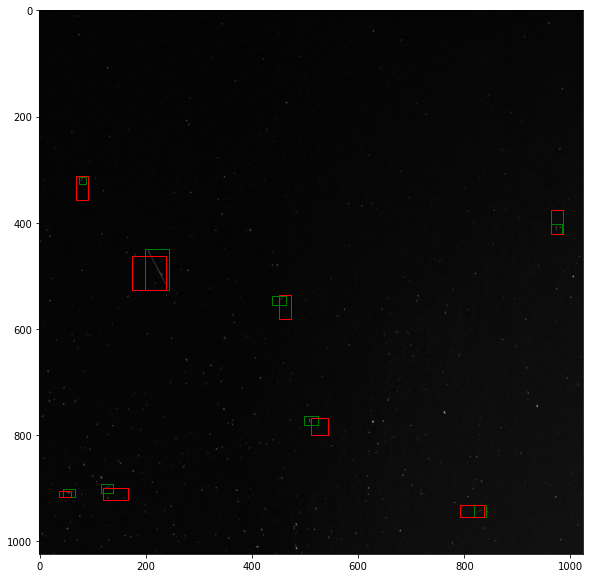

**Case 2 begins...**
Which gt box has maximum overlap with each anchor: [0 0 0 ... 0 0 0]
Corresponding Maximum IOU for each anchor: [0. 0. 0. ... 0. 0. 0.]
LABELLING GT ANCHORS...
No of positive labels:
(8,)
No of negative labels:
(8468,)


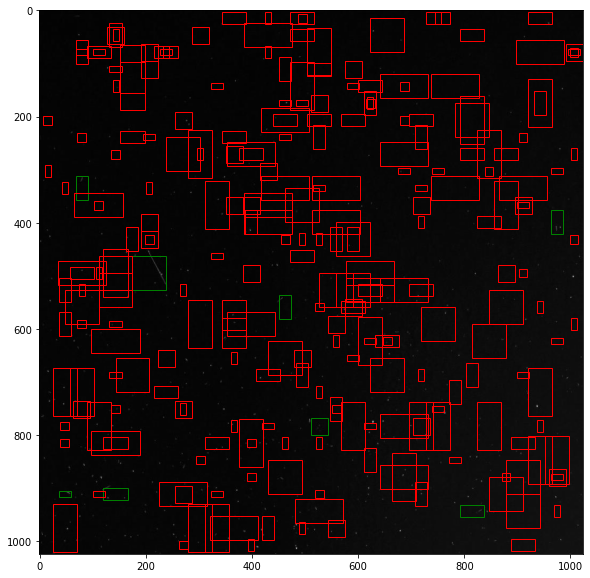

Getting regression outputs...
Correct regression outputs of valid anchor locations=
[[ 41.807686    9.103999    1.9306936   0.709479 ]
 [ 29.5625     12.875       1.5841202   1.0560527]
 [ 20.903843   18.207998    1.2375464   1.4026262]
 ...
 [-32.4375    -49.125       1.5841202   1.0560527]
 [-16.21875   -24.5625      0.8909729   0.3629055]
 [-22.936752  -69.47317     1.2375455   1.4026252]]
Final labels shape: (9216,)
Final locaions shape: (9216, 4)


In [ ]:
a,b = get_gt_targets(crismis_dataset['train'],61)

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataset):
        self.dataset = dataset # crismis_dataset['train']

  def __len__(self):
        return len(self.dataset)

  def __getitem__(self, index):
        inputs = self.dataset[index][0].view(1,3,1024,1024)
        anchor_labels,anchor_locations = get_gt_targets_wo_print(self.dataset,index)
        return inputs,anchor_labels,anchor_locations

tensor_dataset = {x: Dataset(crismis_dataset[x]) 
             for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(tensor_dataset[x], batch_size=1,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(tensor_dataset[x]) for x in ['train', 'valid']}

In [ ]:
len(dataloaders['train'])

124

In [ ]:
for inputs,labels,locs in dataloaders['train']:
        print(inputs[0].shape)
        print(labels[0].shape)
        print(locs[0].shape)
        break

torch.Size([1, 3, 1024, 1024])
torch.Size([9216])
torch.Size([9216, 4])


### Final positive and negative anchors based on Ground truth 

In [ ]:
# def resnet50_with_fpn(num_classes, pretrained=False, **kwargs):
#     """Constructs a ResNet-50 model.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = ResNet(num_classes, Bottleneck, [3, 4, 6, 3], **kwargs)
#     # if pretrained:
#         model.load_state_dict(model_zoo.load_url(model_urls['resnet50'], model_dir='.'), strict=False)
#     return model

In [ ]:
# class PyramidFeatures(nn.Module):
#     def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
#         super(PyramidFeatures, self).__init__()

#         # upsample C5 to get P5 from the FPN paper
#         self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
#         self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
#         self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

#         # add P5 elementwise to C4
#         self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
#         self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
#         self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

#         # add P4 elementwise to C3
#         self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
#         self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

#         # "P6 is obtained via a 3x3 stride-2 conv on C5"
#         self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

#         # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
#         self.P7_1 = nn.ReLU()
#         self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

#     def forward(self, inputs):
#         C3, C4, C5 = inputs

#         P5_x = self.P5_1(C5)
#         P5_upsampled_x = self.P5_upsampled(P5_x)
#         P5_x = self.P5_2(P5_x)

#         P4_x = self.P4_1(C4)
#         P4_x = P5_upsampled_x + P4_x
#         P4_upsampled_x = self.P4_upsampled(P4_x)
#         P4_x = self.P4_2(P4_x)

#         P3_x = self.P3_1(C3)
#         P3_x = P3_x + P4_upsampled_x
#         P3_x = self.P3_2(P3_x)

#         P6_x = self.P6(C5)

#         P7_x = self.P7_1(P6_x)
#         P7_x = self.P7_2(P7_x)

#         return [P3_x, P4_x, P5_x, P6_x, P7_x]

# # Regression Head
# class RegressionModel(nn.Module):
#     def __init__(self, num_features_in, num_anchors=9, feature_size=256):
#         super(RegressionModel, self).__init__()

#         self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
#         self.act1 = nn.ReLU()

#         self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
#         self.act2 = nn.ReLU()

#         self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
#         self.act3 = nn.ReLU()

#         self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
#         self.act4 = nn.ReLU()

#         self.output = nn.Conv2d(feature_size, num_anchors * 4, kernel_size=3, padding=1)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.act1(out)

#         out = self.conv2(out)
#         out = self.act2(out)

#         out = self.conv3(out)
#         out = self.act3(out)

#         out = self.conv4(out)
#         out = self.act4(out)

#         out = self.output(out)

#         # out is B x C x W x H, with C = 4*num_anchors
#         out = out.permute(0, 2, 3, 1)

#         return out.contiguous().view(out.shape[0], -1, 4)

# # Classification Head
# class ClassificationModel(nn.Module):
#     def __init__(self, num_features_in, num_anchors=9, num_classes=2, prior=0.01, feature_size=256):
#         super(ClassificationModel, self).__init__()

#         self.num_classes = num_classes
#         self.num_anchors = num_anchors

#         self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
#         self.act1 = nn.ReLU()

#         self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
#         self.act2 = nn.ReLU()

#         self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
#         self.act3 = nn.ReLU()

#         self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
#         self.act4 = nn.ReLU()

#         self.output = nn.Conv2d(feature_size, num_anchors * num_classes, kernel_size=3, padding=1)
#         self.output_act = nn.Sigmoid()

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.act1(out)

#         out = self.conv2(out)
#         out = self.act2(out)

#         out = self.conv3(out)
#         out = self.act3(out)

#         out = self.conv4(out)
#         out = self.act4(out)

#         out = self.output(out)
#         out = self.output_act(out)

#         # out is B x C x W x H, with C = n_classes + n_anchors
#         out1 = out.permute(0, 2, 3, 1)

#         batch_size, width, height, channels = out1.shape

#         out2 = out1.view(batch_size, width, height, self.num_anchors, self.num_classes)

#         return out2.contiguous().view(x.shape[0], -1, self.num_classes)


# class ResNet(nn.Module):

#     def __init__(self, num_classes, block, layers):
#         self.inplanes = 64
#         super(ResNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

#         if block == BasicBlock:
#             fpn_sizes = [self.layer2[layers[1] - 1].conv2.out_channels, self.layer3[layers[2] - 1].conv2.out_channels,
#                          self.layer4[layers[3] - 1].conv2.out_channels]
#         elif block == Bottleneck:
#             fpn_sizes = [self.layer2[layers[1] - 1].conv3.out_channels, self.layer3[layers[2] - 1].conv3.out_channels,
#                          self.layer4[layers[3] - 1].conv3.out_channels]
#         else:
#             raise ValueError(f"Block type {block} not understood")

#         self.fpn = PyramidFeatures(fpn_sizes[0], fpn_sizes[1], fpn_sizes[2])

#         self.regressionModel = RegressionModel(256)
#         self.classificationModel = ClassificationModel(256, num_classes=num_classes)

#         self.anchors = Anchors()

#         self.regressBoxes = BBoxTransform()

#         self.clipBoxes = ClipBoxes()


#         self.focalLoss = losses.FocalLoss()

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

#         prior = 0.01

#         self.classificationModel.output.weight.data.fill_(0)
#         self.classificationModel.output.bias.data.fill_(-math.log((1.0 - prior) / prior))

#         self.regressionModel.output.weight.data.fill_(0)
#         self.regressionModel.output.bias.data.fill_(0)

#         self.freeze_bn()

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = [block(self.inplanes, planes, stride, downsample)]
#         self.inplanes = planes * block.expansion
#         for i in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def freeze_bn(self):
#         '''Freeze BatchNorm layers.'''
#         for layer in self.modules():
#             if isinstance(layer, nn.BatchNorm2d):
#                 layer.eval()

#     def forward(self, inputs):

#         if self.training:
#             img_batch, annotations = inputs
#         else:
#             img_batch = inputs

#         x = self.conv1(img_batch)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x1 = self.layer1(x)
#         x2 = self.layer2(x1)
#         x3 = self.layer3(x2)
#         x4 = self.layer4(x3)

#         features = self.fpn([x2, x3, x4])

#         regression = torch.cat([self.regressionModel(feature) for feature in features], dim=1)

#         classification = torch.cat([self.classificationModel(feature) for feature in features], dim=1)



In [ ]:
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

In [ ]:
# backbone = resnet_fpn_backbone('resnet50', pretrained=True)
# x = torch.rand(1,3,1024,1024)
# output = backbone(x)
# print(backbone)
# # print([(k, v.shape) for k, v in output.items()])

In [ ]:
# Details of the Vgg network and its output shape:(1,512,32,32)
VGG_model = torchvision.models.vgg16(pretrained=True)
# Resnet50 = torchvision.models.resnet50(pretrained=True)
# fe = list(Resnet50.features)
fe = list(VGG_model.features)
mid_channels = 512
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
n_anchor = 9 # Number of anchors at each location
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
# Initialising the layer weights with values from Gaussian(0,0.01)
# conv sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
print(fe)
# print(conv1)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
class rpn(nn.Module):
    def __init__(self):
        super(rpn, self).__init__()
        self.backbone = torch.nn.Sequential(*fe,conv1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0)
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
        
    def forward(self, input_image):
        out_map = self.backbone(input_image)
        pred_cls_scores = self.cls_layer(out_map)
        pred_anchor_locs = self.reg_layer(out_map)
        return pred_cls_scores, pred_anchor_locs
    

In [ ]:
rpn_model_init = rpn().to(device)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, pred_labels, target_labels, class_weights):
        BCE_loss = F.cross_entropy(pred_labels, target_labels.long(), ignore_index = -1, weight = class_weights)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss
        # if self.reduce:
        #     return torch.mean(F_loss)
        # else:
        #     return F_loss

In [ ]:
def train_model(model, focal_loss, start_epoch = 0,num_epochs=25):
  weights = [0.05, 0.95]
  class_weights = torch.FloatTensor(weights).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  # scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
  since = time.time()
  model_wts = copy.deepcopy(model.state_dict())
  best_loss = 100.0
        
  for epoch in range(num_epochs):        
      print('Epoch {}/{}'.format(epoch + start_epoch, start_epoch+ num_epochs-1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'valid']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode
                
          cls_loss = 0.0
          reg_loss = 0.0  
          running_loss = 0.0            
          total_cls_loss = 0.0
          total_reg_loss = 0.0
          total_epoch_loss = 0.0
          index = -1

          # Iterate over data.
          for inputs, labels, locations in dataloaders[phase]:
            # Batch size 1
              index+=1
              inputs = inputs[0].to(device)
              target_labels_np = labels[0].data.numpy()
              pos_arr = np.where(target_labels_np > 0)[0]
              target_labels = labels[0].to(device)
              target_locs = locations[0].to(device)
              pos = target_labels > 0
              # zero the parameter gradients
              optimizer.zero_grad()
              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  pred_labels, pred_locs = model(inputs)
                  if torch.isnan(pred_locs ).any():
                      print("Nan in output prediction:", index)
                      return None
                  pred_labels = pred_labels.permute(0, 2, 3, 1).contiguous()
                  pred_labels = pred_labels.view(1, 32, 32, 9, 2).contiguous().view(-1, 2)
                  pred_locs = pred_locs.permute(0, 2, 3, 1).contiguous().view(-1, 4)
                  # rpn_cls_loss = F.cross_entropy(pred_labels, target_labels.long(), ignore_index = -1,weight = class_weights)
                  rpn_cls_loss = focal_loss(pred_labels,target_labels, class_weights)
                  # rpn_lambda = 1.
                
                  if not(pos_arr.size == 0):
                      mask = pos.unsqueeze(1).expand_as(pred_locs)
                      mask_loc_preds = pred_locs[mask].view(-1,4)
                      mask_loc_targets = target_locs[mask].view(-1, 4)
                      x = torch.abs(mask_loc_targets - mask_loc_preds)
                      rpn_loc_loss = (((x < 1).float() * 0.5 * x*x) + ((x >= 1).float() * (x-0.5))).sum()
#                       print(rpn_loc_loss)
                      rpn_loc_loss_item = rpn_loc_loss.item()
                      # N_reg = (pos).float().sum()
                      # rpn_loc_loss = rpn_loc_loss/ N_reg
                      rpn_loss = rpn_cls_loss +  rpn_loc_loss
                  else:
                      rpn_loc_loss_item = 0
                      rpn_loss = rpn_cls_loss
                  
                
                  # backward + optimize only if in training phase
                  if phase == 'train':
                      rpn_loss.backward()
                      optimizer.step()

              # statistics
              cls_loss += rpn_cls_loss.item()
              reg_loss += rpn_loc_loss_item
              running_loss += rpn_loss.item()
          # if phase == 'train':
          #     scheduler.step()

          total_cls_loss = cls_loss / dataset_sizes[phase]
          total_reg_loss = reg_loss / dataset_sizes[phase]
          total_epoch_loss = running_loss / dataset_sizes[phase]
            
          
          writer.add_scalars('{} Loss graph'.format(phase), {'Class loss':total_cls_loss,
                                    'regression loss':total_reg_loss,
                                    'Total loss': total_epoch_loss}, epoch + start_epoch)

          print('{} rpn_cls Loss: {:.4f}       {} rpn_reg Loss: {:.4f}       {} Total Loss: {:.4f}'.format(phase, total_cls_loss,phase, total_reg_loss,phase, total_epoch_loss))

          # deep copy the model
          if phase == 'train' and total_epoch_loss < best_loss:
              best_loss = total_epoch_loss
              model_wts = copy.deepcopy(model.state_dict())
      print()
  
  writer.close()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best Loss: {:4f}'.format(best_loss))

  # load model weights
  model.load_state_dict(model_wts)
  return model

In [ ]:
fl = FocalLoss()
model_50_focal_loss = train_model(rpn_model_init, fl, 0, 50)

Epoch 0/49
----------
train rpn_cls Loss: 0.1593       train rpn_reg Loss: 1.5579       train Total Loss: 1.7172
valid rpn_cls Loss: 0.1556       valid rpn_reg Loss: 1.4785       valid Total Loss: 1.6340

Epoch 1/49
----------
train rpn_cls Loss: 0.1399       train rpn_reg Loss: 1.0000       train Total Loss: 1.1399
valid rpn_cls Loss: 0.1386       valid rpn_reg Loss: 1.5276       valid Total Loss: 1.6662

Epoch 2/49
----------
train rpn_cls Loss: 0.1389       train rpn_reg Loss: 1.0427       train Total Loss: 1.1817
valid rpn_cls Loss: 0.1452       valid rpn_reg Loss: 1.5192       valid Total Loss: 1.6644

Epoch 3/49
----------
train rpn_cls Loss: 0.1296       train rpn_reg Loss: 0.9730       train Total Loss: 1.1026
valid rpn_cls Loss: 0.1330       valid rpn_reg Loss: 1.5317       valid Total Loss: 1.6647

Epoch 4/49
----------
train rpn_cls Loss: 0.1201       train rpn_reg Loss: 0.9597       train Total Loss: 1.0798
valid rpn_cls Loss: 0.1287       valid rpn_reg Loss: 1.6288       v

In [ ]:
torch.save(model_50_focal_loss,'/content/drive/My Drive/retinanet/model_50_focal_loss.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type rpn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
!ls

drive  pascal_voc_roboflow  runs  sample_data


In [ ]:
!mv runs drive/My\ Drive/retinanet/runs

In [ ]:
model_after_50 = torch.load('/content/drive/My Drive/retinanet/model_50_focal_loss.pth')

In [ ]:
fl = FocalLoss()
model_100_focal_loss = train_model(model_after_50, fl, 50, 50)

Epoch 50/99
----------
train rpn_cls Loss: 0.0594       train rpn_reg Loss: 0.0777       train Total Loss: 0.1371
valid rpn_cls Loss: 0.0803       valid rpn_reg Loss: 2.1815       valid Total Loss: 2.2618

Epoch 51/99
----------
train rpn_cls Loss: 0.0576       train rpn_reg Loss: 0.0796       train Total Loss: 0.1372
valid rpn_cls Loss: 0.0792       valid rpn_reg Loss: 2.1585       valid Total Loss: 2.2377

Epoch 52/99
----------
train rpn_cls Loss: 0.0573       train rpn_reg Loss: 0.0803       train Total Loss: 0.1377
valid rpn_cls Loss: 0.0794       valid rpn_reg Loss: 2.1614       valid Total Loss: 2.2408

Epoch 53/99
----------
train rpn_cls Loss: 0.0571       train rpn_reg Loss: 0.0785       train Total Loss: 0.1355
valid rpn_cls Loss: 0.0822       valid rpn_reg Loss: 2.1562       valid Total Loss: 2.2383

Epoch 54/99
----------
train rpn_cls Loss: 0.0561       train rpn_reg Loss: 0.0749       train Total Loss: 0.1310
valid rpn_cls Loss: 0.0786       valid rpn_reg Loss: 2.2380   

In [ ]:
torch.save(model_100_focal_loss,'/content/drive/My Drive/retinanet/model_100_focal_loss.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type rpn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
!mv runs drive/My\ Drive/retinanet/runs2

In [ ]:
model_after_100 = torch.load('/content/drive/My Drive/retinanet/model_100_focal_loss.pth')

In [ ]:
fl = FocalLoss()
model_100_focal_loss_constantlr = train_model(model_after_50, fl, 50, 50)

Epoch 50/99
----------
train rpn_cls Loss: 0.0588       train rpn_reg Loss: 0.0770       train Total Loss: 0.1358
valid rpn_cls Loss: 0.0815       valid rpn_reg Loss: 2.1741       valid Total Loss: 2.2556

Epoch 51/99
----------
train rpn_cls Loss: 0.0572       train rpn_reg Loss: 0.0771       train Total Loss: 0.1343
valid rpn_cls Loss: 0.0785       valid rpn_reg Loss: 2.2167       valid Total Loss: 2.2952

Epoch 52/99
----------
train rpn_cls Loss: 0.0580       train rpn_reg Loss: 0.0804       train Total Loss: 0.1384
valid rpn_cls Loss: 0.0803       valid rpn_reg Loss: 2.2418       valid Total Loss: 2.3220

Epoch 53/99
----------
train rpn_cls Loss: 0.0562       train rpn_reg Loss: 0.0798       train Total Loss: 0.1360
valid rpn_cls Loss: 0.0819       valid rpn_reg Loss: 2.2058       valid Total Loss: 2.2877

Epoch 54/99
----------
train rpn_cls Loss: 0.0559       train rpn_reg Loss: 0.0758       train Total Loss: 0.1317
valid rpn_cls Loss: 0.0790       valid rpn_reg Loss: 2.2410   

In [ ]:
torch.save(model_100_focal_loss_constantlr,'/content/drive/My Drive/retinanet/model_100_constant_lr.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type rpn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
!mv runs drive/My\ Drive/retinanet/runs3

In [ ]:
model_100_constant_lr = torch.load('/content/drive/My Drive/retinanet/model_100_constant_lr.pth')

### Proposal layer

In [ ]:
def Show_predicted_anchors(data,index,model_final,rpn):
    ind = index
    labels_np, loc_np = get_gt_targets_wo_print(data,index)
    labels = torch.from_numpy(labels_np)
    input_image = data[index][0].view(1,3,1024,1024)
    gt_bbox = np.array(data[index][1][0],dtype=np.float32)# y1,x1,y2,x2
    model_cpu= model_final.to('cpu')
    cls_output, reg_output = model_cpu(input_image)
    outputs = cls_output.permute(0, 2, 3, 1).contiguous()
    outputs = outputs.view(1, 32, 32, 9, 2).contiguous().view(-1, 2)
    loss = fl(pred_labels,target_labels, class_weights)
    print("Loss function value for this image=",loss)
    
    soft= nn.Softmax(dim=1)
    output = soft(outputs)
    objectness_score = output[:,1]
    score_numpy = objectness_score.data.numpy()
    
    rpn_cpu = rpn.to('cpu')
    output_untrained, _ = rpn_cpu(input_image)
    output_untrained = output_untrained.permute(0, 2, 3, 1).contiguous()
    output_untrained = output_untrained.view(1, 32, 32, 9, 2).contiguous().view(-1, 2)
    output_untrained = soft(output_untrained)[:,1]
    score_numpy_untrained = output_untrained.data.numpy()
    
    nms_thresh = 0.6
    n_train_pre_nms = 12000
    n_train_post_nms = 2000
    n_test_pre_nms = 6000
    n_test_post_nms = 300
    ratios = [0.5, 1, 2]
    anchor_scales = [16,32,64]
    fe_size = 32

    anchors = np.zeros((len(ratios) * len(anchor_scales)*fe_size *fe_size, 4),dtype=np.float32)
    ctr =  np.zeros((fe_size*fe_size,2),dtype=np.float32)

    # Generate centers for each feature map pixel
    pts = np.arange(31, (fe_size+1) * 32-1, 32)
    index = 0
    for x in range(len(pts)):
        for y in range(len(pts)):
            ctr[index, 1] = pts[x] - 16
            ctr[index, 0] = pts[y] - 16
            index +=1

  # Code to generate anchors at a location in Fmap
    index = 0
    for c in ctr:
        ctr_y, ctr_x = c
        for i in range(len(ratios)):
            for j in range(len(anchor_scales)):
                h = anchor_scales[j] * np.sqrt(ratios[i])
                w = anchor_scales[j] * np.sqrt(1./ ratios[i])
                anchors[index, 0] = ctr_y - h / 2.
                anchors[index, 1] = ctr_x - w / 2.
                anchors[index, 2] = ctr_y + h / 2.
                anchors[index, 3] = ctr_x + w / 2.
                index += 1
    indices_inside = np.where(
      (anchors[:, 0] >= 0) &
      (anchors[:, 1] >= 0) &
      (anchors[:, 2] < 1024) &
      (anchors[:, 3] < 1024)
    )[0]
    roi = anchors
    y1 = roi[:, 0]
    x1 = roi[:, 1]
    y2 = roi[:, 2]
    x2 = roi[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = score_numpy.argsort()[::-1]
    keep = []
    # Remove overlapping predictions
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= nms_thresh)[0]
        order = order[inds + 1]
    final_order_indices = np.intersect1d(keep[:20], indices_inside, assume_unique = True)
#     final_order_indices = np.where(labels_np==1)[0]
    print("Indices obtained")
    print(final_order_indices)
    print("Initial objectness scores at these indices")
    print(score_numpy_untrained[final_order_indices]) 
    print("Final Objectness scores:")
    print(score_numpy[final_order_indices])
    print("Original Label values at these indices")
    print(labels_np[final_order_indices])
    # Final regions of interest boxes and scores as output by the proposal network 
    print("No of proposals:", len(roi[final_order_indices]))
    imshow(data[ind][0],gt_bbox,roi[final_order_indices])

In [ ]:
def Show_Final_Proposals(data,index,model_final):
  ind = index
  labels_np, loc_np = get_gt_targets_wo_print(data,index)
  labels = torch.from_numpy(labels_np)
  input_image = data[index][0].view(1,3,1024,1024)
  gt_bbox = np.array(data[index][1][0],dtype=np.float32)# y1,x1,y2,x2
  model_cpu= model_final.to('cpu')
  cls_output, reg_output = model_cpu(input_image)
  outputs = cls_output.permute(0, 2, 3, 1).contiguous()
  outputs = outputs.view(1, 32, 32, 9, 2).contiguous().view(-1, 2)
  
  soft= nn.Softmax(dim=1)
  cls_output = soft(outputs)
  objectness_score = cls_output[:,1]
  score_numpy = objectness_score.data.numpy()
  
  nms_thresh = 0.6
  n_train_pre_nms = 12000
  n_train_post_nms = 2000
  n_test_pre_nms = 6000
  n_test_post_nms = 300
  ratios = [0.5, 1, 2]
  anchor_scales = [16,32,64]
  fe_size = 32

  anchors = np.zeros((len(ratios) * len(anchor_scales)*fe_size *fe_size, 4),dtype=np.float32)
  ctr =  np.zeros((fe_size*fe_size,2),dtype=np.float32)

  # Generate centers for each feature map pixel
  pts = np.arange(31, (fe_size+1) * 32-1, 32)
  index = 0
  for x in range(len(pts)):
      for y in range(len(pts)):
          ctr[index, 1] = pts[x] - 16
          ctr[index, 0] = pts[y] - 16
          index +=1

# Code to generate anchors at a location in Fmap
  index = 0
  for c in ctr:
      ctr_y, ctr_x = c
      for i in range(len(ratios)):
          for j in range(len(anchor_scales)):
              h = anchor_scales[j] * np.sqrt(ratios[i])
              w = anchor_scales[j] * np.sqrt(1./ ratios[i])
              anchors[index, 0] = ctr_y - h / 2.
              anchors[index, 1] = ctr_x - w / 2.
              anchors[index, 2] = ctr_y + h / 2.
              anchors[index, 3] = ctr_x + w / 2.
              index += 1
  indices_inside = np.where(
    (anchors[:, 0] >= 0) &
    (anchors[:, 1] >= 0) &
    (anchors[:, 2] < 1024) &
    (anchors[:, 3] < 1024)
  )[0]
  reg_output = reg_output.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
  pred_anchor_locs_numpy = reg_output[0].data.numpy()

  anc_height = anchors[:, 2] - anchors[:, 0]
  anc_width = anchors[:, 3] - anchors[:, 1]
  anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
  anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

  dy = pred_anchor_locs_numpy[:, 0::4]
  dx = pred_anchor_locs_numpy[:, 1::4]
  dh = pred_anchor_locs_numpy[:, 2::4]
  dw = pred_anchor_locs_numpy[:, 3::4]

  # get the predicted box centers, height and width
  ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
  ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
  h = np.exp(dh) * anc_height[:, np.newaxis]
  w = np.exp(dw) * anc_width[:, np.newaxis]

  # Convert loc to y1,x1,y2,x2 format
  roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchors.dtype)
  roi[:, 0::4] = ctr_y - 0.5 * h
  roi[:, 1::4] = ctr_x - 0.5 * w
  roi[:, 2::4] = ctr_y + 0.5 * h
  roi[:, 3::4] = ctr_x + 0.5 * w
  img_size = (1024, 1024) #Image size
  roi[:, slice(0, 4, 2)] = np.clip(
              roi[:, slice(0, 4, 2)], 0, img_size[0])
  roi[:, slice(1, 4, 2)] = np.clip(
      roi[:, slice(1, 4, 2)], 0, img_size[1])
  # print("Valid ROI's")
  # print(roi)

  # Keep only the regions larger than minimum size
  # hs = roi[:, 2] - roi[:, 0]
  # ws = roi[:, 3] - roi[:, 1]
  # keep = np.where((hs >= min_size) & (ws >= min_size))[0]
  # roi = roi[keep, :]

  y1 = roi[:, 0]
  x1 = roi[:, 1]
  y2 = roi[:, 2]
  x2 = roi[:, 3]

  areas = (x2 - x1 + 1) * (y2 - y1 + 1)
  order = score_numpy.argsort()[::-1]
  keep = []
  # Remove overlapping predictions
  while order.size > 0:
      i = order[0]
      keep.append(i)
      xx1 = np.maximum(x1[i], x1[order[1:]])
      yy1 = np.maximum(y1[i], y1[order[1:]])
      xx2 = np.minimum(x2[i], x2[order[1:]])
      yy2 = np.minimum(y2[i], y2[order[1:]])
      w = np.maximum(0.0, xx2 - xx1 + 1)
      h = np.maximum(0.0, yy2 - yy1 + 1)
      inter = w * h
      ovr = inter / (areas[i] + areas[order[1:]] - inter)
      inds = np.where(ovr <= nms_thresh)[0]
      order = order[inds + 1]
  final_order_indices = np.intersect1d(keep[:20], indices_inside, assume_unique = True)
  print("Final Objectness scores:")
  print(score_numpy[final_order_indices])
  # # Final regions of interest boxes and scores as output by the proposal network 
  # print("No of proposals:", len(roi[final_order_indices]))
  imshow(data[ind][0],gt_bbox,anchors[final_order_indices])
  imshow(data[ind][0],gt_bbox,roi[final_order_indices])
 

Final Objectness scores:
[0.8089481  0.83976877 0.8304211  0.80968845 0.8086033  0.83135384
 0.8365442  0.9185653  0.813025   0.8509179  0.8297024  0.8315669
 0.8602548  0.8615865  0.86172944 0.8384997  0.9417904  0.8485402
 0.8158003  0.8443038 ]


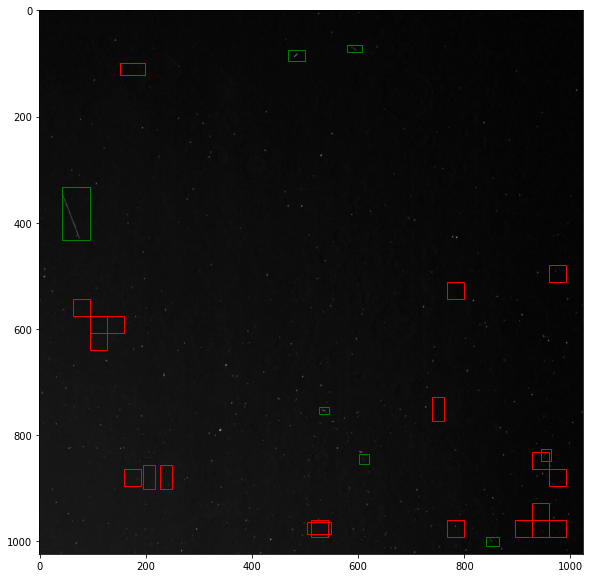

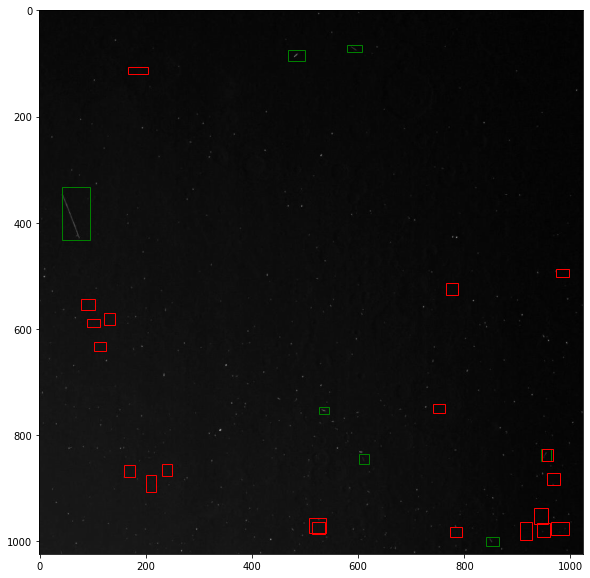

Final Objectness scores:
[0.8546636  0.93250513 0.8291394  0.8581126  0.8495188  0.89328176
 0.8602398  0.83540225 0.8319153  0.83041364 0.8517486  0.8624925
 0.8683139  0.84045714 0.88081396 0.85496926 0.863475   0.8463805
 0.8293311  0.87630284]


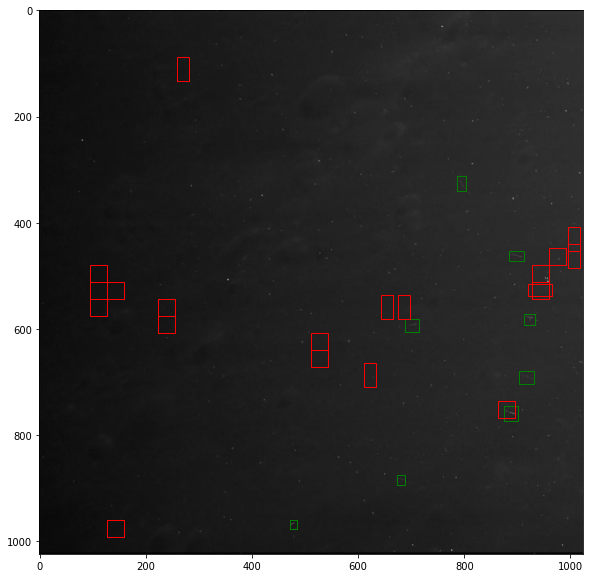

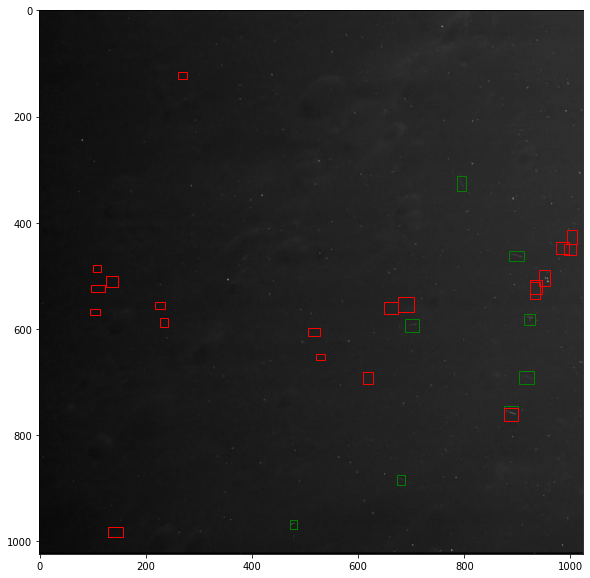

Final Objectness scores:
[0.7954889  0.7997365  0.8250373  0.8629418  0.81028575 0.8337906
 0.8789729  0.80418175 0.80239195 0.87326056 0.86256456 0.850467
 0.7975158  0.8217706  0.88905716 0.8339175  0.79751223 0.84863436
 0.9275418  0.9187908 ]


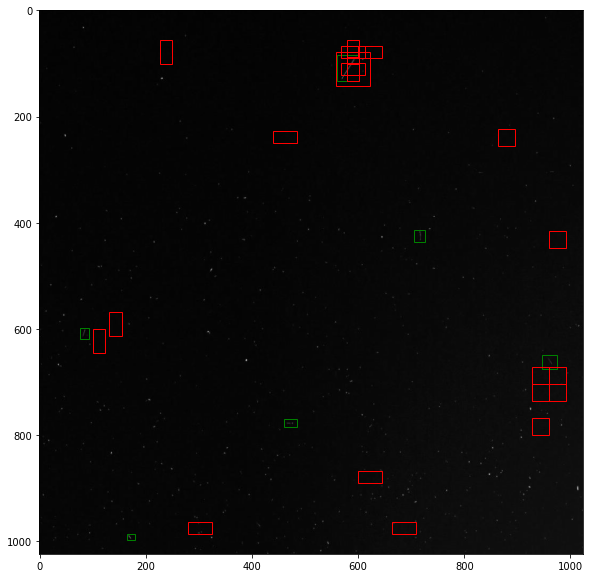

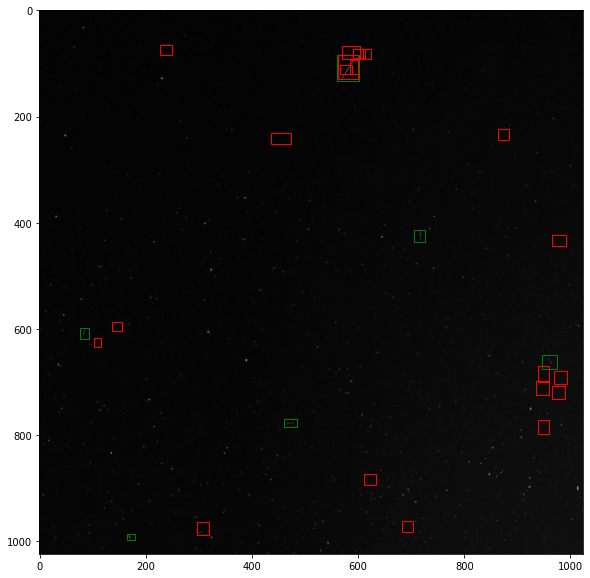

Final Objectness scores:
[0.9240025  0.85192025 0.90921575 0.8677872  0.88789725 0.8503857
 0.8852566  0.901556   0.8728027  0.9249116  0.88027954 0.888966
 0.84633017 0.8553484  0.8478617  0.907136   0.87171847 0.9174485
 0.8883959  0.86410636]


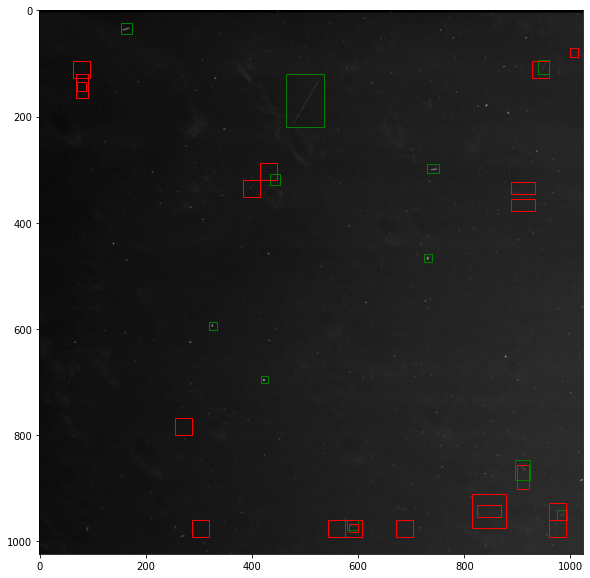

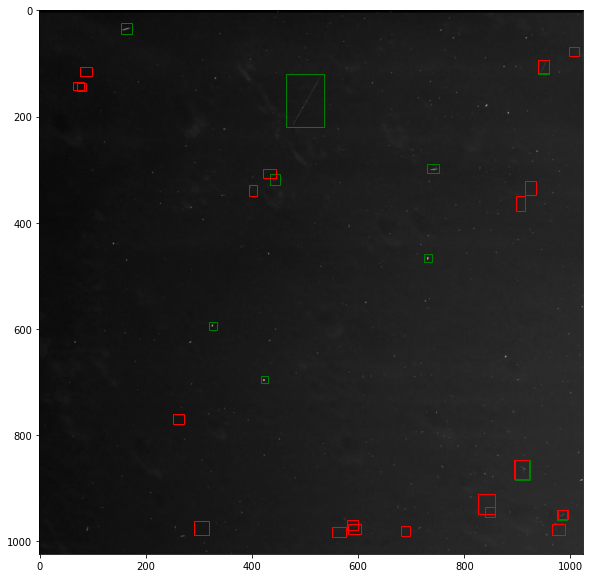

Final Objectness scores:
[0.78751725 0.8617783  0.80960685 0.78898555 0.86016643 0.79298097
 0.848642   0.8197595  0.8168946  0.7809192  0.8624867  0.87824667
 0.8467092  0.78173935 0.82385916 0.7872532  0.7911555  0.7853047
 0.84473044 0.84056556]


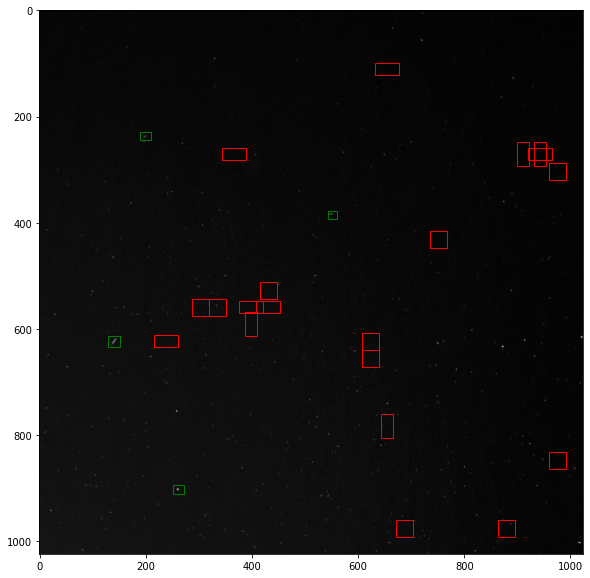

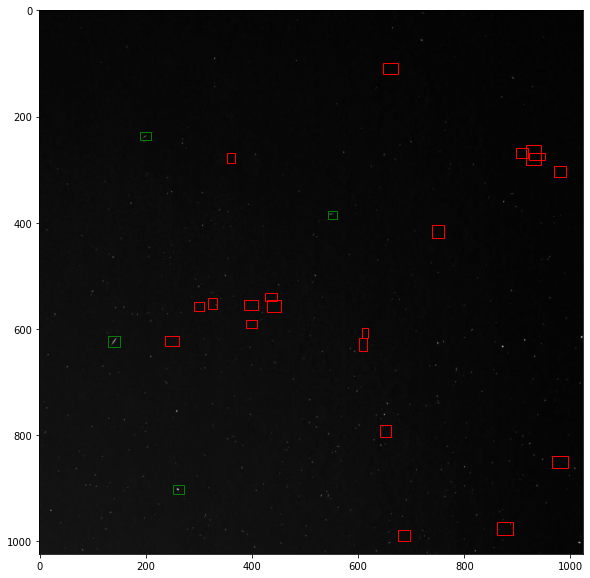

Final Objectness scores:
[0.77810454 0.75281054 0.78274465 0.7240237  0.74203855 0.7160701
 0.72577447 0.7171579  0.7232938  0.7428861  0.7720944  0.7255726
 0.736952   0.7753735  0.90289503 0.80265534 0.73697203 0.75310206
 0.7649427  0.7469284 ]


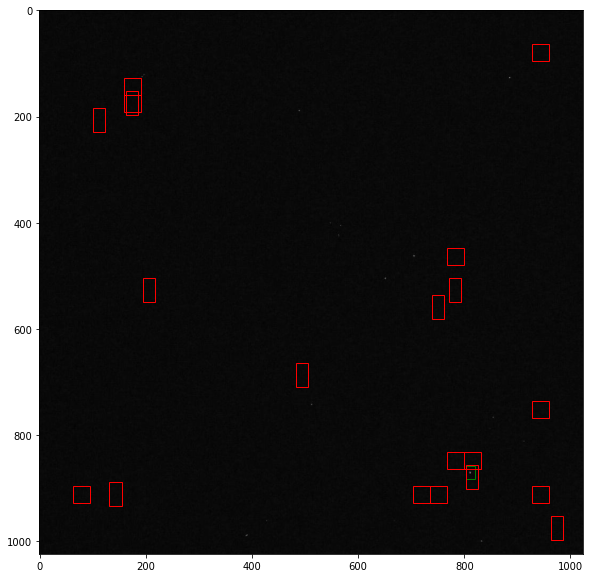

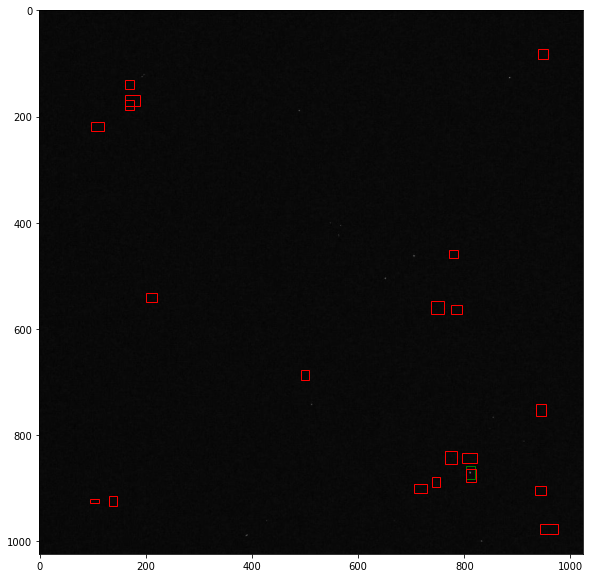

In [ ]:
for index in range(6):
  Show_Final_Proposals(crismis_dataset['train'],index,model_100_constant_lr)